In [1]:
!pip install torch==1.12.1
!pip install torchdata
!pip install -U torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 11.3 MB/s 
     |██████████████████████████████  | 834.1 MB 1.3 MB/s eta 0:00:45tcmalloc: large alloc 1147494400 bytes == 0x396e2000 @  0x7fd2e6c7d615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 7.0 kB/s 
     |████████████████████████████████| 140 kB 68.7 MB/s 
     |████████████████████████████████| 849 kB 59.6 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
     |████████████████████████████████| 317

In [2]:
CBOW_N_WORDS = 4
SKIPGRAM_N_WORDS = 4

MIN_WORD_FREQUENCY = 50
MAX_SEQUENCE_LENGTH = 256

EMBED_DIMENSION = 300
EMBED_MAX_NORM = 1

import torch
from functools import partial
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR


def get_english_tokenizer():
    """
    Documentation:
    https://pytorch.org/text/stable/_modules/torchtext/data/utils.html#get_tokenizer
    """
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer


def get_data_iterator(ds_name, ds_type, data_dir):
    if ds_name == "WikiText2":
        data_iter = WikiText2(root=data_dir, split=(ds_type))
    elif ds_name == "WikiText103":
        data_iter = WikiText103(root=data_dir, split=(ds_type))
    else:
        raise ValueError("Choose dataset from: WikiText2, WikiText103")
    data_iter = to_map_style_dataset(data_iter)
    return data_iter


def build_vocab(data_iter, tokenizer):
    """Builds vocabulary from iterator"""
    
    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"],
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab


def collate_cbow(batch, text_pipeline):
    """
    Collate_fn for CBOW model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=CBOW_N_WORDS past words 
    and N=CBOW_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is N=CBOW_N_WORDS*2 context words.
    Each element in `batch_output` is a middle word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def collate_skipgram(batch, text_pipeline):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            for output in outputs:
                batch_input.append(input_)
                batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
):

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)
        ipdb.set_trace()
        
    text_pipeline = lambda x: vocab(tokenizer(x))

    if model_name == "cbow":
        collate_fn = collate_cbow
    elif model_name == "skipgram":
        collate_fn = collate_skipgram
    else:
        raise ValueError("Choose model from: cbow, skipgram")

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
    )
    return dataloader, vocab

import os
import yaml
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR



def get_model_class(model_name: str):
    if model_name == "cbow":
        return CBOW_Model
        #return Model
    elif model_name == "skipgram":
        return SkipGram_Model
    else:
        raise ValueError("Choose model_name from: cbow, skipgram")
        return


def get_optimizer_class(name: str):
    if name == "Adam":
        return optim.Adam
    else:
        raise ValueError("Choose optimizer from: Adam")
        return
    

def get_lr_scheduler(optimizer, total_epochs: int, verbose: bool = True):
    """
    Scheduler to linearly decrease learning rate, 
    so thatlearning rate after the last epoch is 0.
    """
    lr_lambda = lambda epoch: (total_epochs - epoch) / total_epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=verbose)
    return lr_scheduler


def save_config(config: dict, model_dir: str):
    """Save config file to `model_dir` directory"""
    config_path = os.path.join(model_dir, "config.yaml")
    with open(config_path, "w") as stream:
        yaml.dump(config, stream)
        
        
def save_vocab(vocab, model_dir: str):
    """Save vocab file to `model_dir` directory"""
    vocab_path = os.path.join(model_dir, "vocab.pt")
    torch.save(vocab, vocab_path)

import torch.nn as nn


class CBOW_Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x


class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = self.linear(x)
        return x

import os
import numpy as np
import json
import torch


class Trainer:
    """Main class for model training"""
    
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        train_steps,
        val_dataloader,
        val_steps,
        checkpoint_frequency,
        criterion,
        optimizer,
        lr_scheduler,
        device,
        model_dir,
        model_name,
    ):  
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.train_steps = train_steps
        self.val_dataloader = val_dataloader
        self.val_steps = val_steps
        self.criterion = criterion
        self.optimizer = optimizer
        self.checkpoint_frequency = checkpoint_frequency
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name

        self.loss = {"train": [], "val": []}
        self.model.to(self.device)

    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch()
            self._validate_epoch()
            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
                    epoch + 1,
                    self.epochs,
                    self.loss["train"][-1],
                    self.loss["val"][-1],
                )
            )

            self.lr_scheduler.step()

            if self.checkpoint_frequency:
                self._save_checkpoint(epoch)

    def _train_epoch(self):
        self.model.train()
        running_loss = []

        for i, batch_data in enumerate(self.train_dataloader, 1):
            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.train_steps:
                break

        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.val_dataloader, 1):
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.val_steps:
                    break

        epoch_loss = np.mean(running_loss)
        self.loss["val"].append(epoch_loss)

    def _save_checkpoint(self, epoch):
        """Save model checkpoint to `self.model_dir` directory"""
        epoch_num = epoch + 1
        if epoch_num % self.checkpoint_frequency == 0:
            model_path = "checkpoint_{}.pt".format(str(epoch_num).zfill(3))
            model_path = os.path.join(self.model_dir, model_path)
            torch.save(self.model, model_path)

    def save_model(self):
        """Save final model to `self.model_dir` directory"""
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """Save train/val loss as json file to `self.model_dir` directory"""
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

In [ ]:
# Loss Functions for Learning Gender-Neutral Word Embeddings https://arxiv.org/pdf/1809.01496.pdf
def JDL1():
    pass

def JD

In [ ]:
import argparse
import yaml
import os
import torch
import torch.nn as nn

model_dir = 'weights/cbow_WikiText2'
model_name = "cbow"
dataset = "WikiText2"
data_dir = 'data/'
train_batch_size = 96
val_batch_size = 96
shuffle = True
optimiz = 'Adam'
learning_rate = 0.025
epochs = 5
train_steps = None
val_steps = None
checkpoint_frequency = None

def train():
    os.makedirs(model_dir)
    
    train_dataloader, vocab = get_dataloader_and_vocab(
        model_name=model_name,
        ds_name=dataset,
        ds_type="train",
        data_dir=data_dir,
        batch_size=train_batch_size,
        shuffle=shuffle,
        vocab=None,
    )

    val_dataloader, _ = get_dataloader_and_vocab(
        model_name=model_name,
        ds_name=dataset,
        ds_type="valid",
        data_dir=data_dir,
        batch_size=val_batch_size,
        shuffle=shuffle,
        vocab=vocab,
    )

    vocab_size = len(vocab.get_stoi())
    print(f"Vocabulary size: {vocab_size}")

    model_class = get_model_class(model_name)
    model = model_class(vocab_size=vocab_size)
    criterion = nn.CrossEntropyLoss()

    optimizer_class = get_optimizer_class(optimiz)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    lr_scheduler = get_lr_scheduler(optimizer, epochs, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    trainer = Trainer(
        model=model,
        epochs=epochs,
        train_dataloader=train_dataloader,
        train_steps=train_steps,
        val_dataloader=val_dataloader,
        val_steps=val_steps,
        criterion=criterion,
        optimizer=optimizer,
        checkpoint_frequency=checkpoint_frequency,
        lr_scheduler=lr_scheduler,
        device=device,
        model_dir=model_dir,
        model_name=model_name,
    )

    trainer.train()
    print("Training finished.")

    trainer.save_model()
    trainer.save_loss()
    save_vocab(vocab, model_dir)
    #save_config(config, model_dir)
    print("Model artifacts saved to folder:", model_dir)
    

In [ ]:
train()

Vocabulary size: 4099
Adjusting learning rate of group 0 to 2.5000e-02.
cuda
Epoch: 1/5, Train Loss=5.29274, Val Loss=5.02610
Adjusting learning rate of group 0 to 2.0000e-02.
Epoch: 2/5, Train Loss=4.96412, Val Loss=4.91551
Adjusting learning rate of group 0 to 1.5000e-02.
Epoch: 3/5, Train Loss=4.84545, Val Loss=4.82693
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 4/5, Train Loss=4.75067, Val Loss=4.75138
Adjusting learning rate of group 0 to 5.0000e-03.
Epoch: 5/5, Train Loss=4.64728, Val Loss=4.68446
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: weights/cbow_WikiText2


In [265]:
import numpy as np
import pandas as pd
import torch
import sys

from sklearn.manifold import TSNE
import plotly.graph_objects as go

folder = "weights/cbow_WikiText2"
#!ls "weights/cbow_wikitext103_20/model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = CBOW_Model(vocab_size=300)
model = torch.load(f"{folder}/model.pt", map_location=device)
#model.load_state_dict(torch.load(f"{folder}/model.pt", map_location=device))
vocab = torch.load(f"{folder}/vocab.pt")

In [266]:
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()
print(embeddings.shape)

norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = vocab.get_itos()
print(embeddings_df_trans.index)

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()

color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("word2vec_visualization.html")

(4099, 300)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Index(['<unk>', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a', '=',
       ...
       'seem', 'sheffield', 'signs', 'swiss', 'toured', 'underneath',
       'violent', 'wagner', 'walking', 'weapon'],
      dtype='object', length=4099)


In [267]:
def get_top_similar(word: str, topN: int = 10):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

dic = get_top_similar("germany")

for word, sim in dic.items():
    print("{}: {:.3f}".format(word, sim))

emb1 = embeddings[vocab["king"]]
emb2 = embeddings[vocab["man"]]
emb3 = embeddings[vocab["woman"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print(word_id)
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

italy: 0.713
france: 0.683
japan: 0.624
1945: 0.614
ireland: 0.595
scotland: 0.587
addition: 0.587
1972: 0.575
1961: 0.573
europe: 0.571
287
king: 0.835
807
henry: 0.597
1716
edward: 0.567
1139
daughter: 0.565
4016
philip: 0.564


In [262]:
import json
import os

"""
Tools for data operations
Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings
Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai
2016
"""

def load_professions():
    professions_file = os.path.join('data', 'professions.json')
    with open(professions_file, 'r') as f:
        professions = json.load(f)
    print('Loaded professions\n' +
          'Format:\n' +
          'word,\n' +
          'definitional female -1.0 -> definitional male 1.0\n' +
          'stereotypical female -1.0 -> stereotypical male 1.0')
    return professions

professions = [["accountant", 0.0, 0.4], ["acquaintance", 0.0, 0.0], ["actor", 0.8, 0.0], ["actress", -1.0, 0.0], ["adjunct_professor", 0.0, 0.5], ["administrator", 0.0, 0.2], ["adventurer", 0.0, 0.5], ["advocate", 0.0, -0.1], ["aide", 0.0, -0.2], ["alderman", 0.7, 0.2], ["alter_ego", 0.0, 0.0], ["ambassador", 0.0, 0.7], ["analyst", 0.0, 0.4], ["anthropologist", 0.0, 0.4], ["archaeologist", 0.0, 0.6], ["archbishop", 0.4, 0.5], ["architect", 0.1, 0.6], ["artist", 0.0, -0.2], ["artiste", -0.1, -0.2], ["assassin", 0.1, 0.8], ["assistant_professor", 0.1, 0.4], ["associate_dean", 0.0, 0.4], ["associate_professor", 0.0, 0.4], ["astronaut", 0.1, 0.8], ["astronomer", 0.1, 0.5], ["athlete", 0.0, 0.7], ["athletic_director", 0.1, 0.7], ["attorney", 0.0, 0.3], ["author", 0.0, 0.1], ["baker", 0.0, -0.1], ["ballerina", -0.5, -0.5], ["ballplayer", 0.2, 0.8], ["banker", 0.0, 0.6], ["barber", 0.5, 0.5], ["baron", 0.6, 0.3], ["barrister", 0.1, 0.4], ["bartender", 0.0, 0.3], ["biologist", 0.0, 0.1], ["bishop", 0.6, 0.4], ["bodyguard", 0.1, 0.9], ["bookkeeper", 0.0, -0.4], ["boss", 0.0, 0.7], ["boxer", 0.1, 0.9], ["broadcaster", -0.1, 0.4], ["broker", 0.1, 0.5], ["bureaucrat", 0.1, 0.5], ["businessman", 0.8, 0.2], ["businesswoman", -0.9, -0.1], ["butcher", 0.1, 0.9], ["butler", 0.5, 0.5], ["cab_driver", 0.1, 0.8], ["cabbie", 0.1, 0.6], ["cameraman", 0.8, 0.1], ["campaigner", 0.0, 0.2], ["captain", 0.1, 0.6], ["cardiologist", 0.1, 0.5], ["caretaker", 0.0, -0.9], ["carpenter", 0.1, 0.8], ["cartoonist", 0.0, 0.5], ["cellist", -0.1, 0.0], ["chancellor", 0.1, 0.6], ["chaplain", 0.1, 0.6], ["character", 0.0, 0.0], ["chef", 0.0, 0.5], ["chemist", 0.0, 0.2], ["choreographer", -0.2, -0.2], ["cinematographer", 0.0, 0.5], ["citizen", 0.0, 0.0], ["civil_servant", 0.0, 0.2], ["cleric", 0.3, 0.3], ["clerk", 0.0, -0.5], ["coach", 0.1, 0.8], ["collector", 0.0, 0.4], ["colonel", 0.1, 0.8], ["columnist", 0.0, 0.2], ["comedian", 0.0, 0.3], ["comic", 0.1, 0.1], ["commander", 0.1, 0.8], ["commentator", 0.0, 0.4], ["commissioner", 0.0, 0.8], ["composer", 0.1, 0.4], ["conductor", 0.1, 0.6], ["confesses", 0.0, 0.0], ["congressman", 0.7, 0.3], ["constable", 0.2, 0.6], ["consultant", 0.0, 0.1], ["cop", 0.2, 0.6], ["correspondent", 0.0, 0.0], ["councilman", 0.8, 0.1], ["councilor", -0.1, -0.1], ["counselor", 0.0, -0.1], ["critic", 0.1, 0.4], ["crooner", 0.2, 0.2], ["crusader", 0.1, 0.7], ["curator", -0.1, 0.2], ["custodian", 0.1, 0.9], ["dad", 1.0, 0.0], ["dancer", -0.1, -0.9], ["dean", 0.2, 0.7], ["dentist", 0.0, 0.7], ["deputy", 0.1, 0.7], ["dermatologist", 0.0, -0.3], ["detective", 0.1, 0.5], ["diplomat", 0.0, 0.5], ["director", 0.1, 0.6], ["disc_jockey", 0.2, 0.6], ["doctor", 0.0, 0.7], ["doctoral_student", 0.0, 0.3], ["drug_addict", 0.0, 0.0], ["drummer", 0.0, 0.9], ["economics_professor", 0.1, 0.6], ["economist", 0.1, 0.5], ["editor", 0.1, 0.4], ["educator", 0.0, -0.5], ["electrician", 0.1, 0.8], ["employee", 0.0, 0.0], ["entertainer", 0.0, 0.0], ["entrepreneur", 0.0, 0.5], ["environmentalist", 0.0, -0.4], ["envoy", 0.1, 0.2], ["epidemiologist", 0.0, 0.0], ["evangelist", 0.1, 0.4], ["farmer", 0.1, 0.8], ["fashion_designer", -0.2, -0.4], ["fighter_pilot", 0.2, 0.7], ["filmmaker", 0.1, 0.3], ["financier", 0.1, 0.5], ["firebrand", 0.0, 0.1], ["firefighter", 0.1, 0.7], ["fireman", 0.8, 0.2], ["fisherman", 0.9, 0.1], ["footballer", 0.4, 0.5], ["foreman", 0.5, 0.4], ["freelance_writer", 0.0, 0.0], ["gangster", 0.2, 0.7], ["gardener", -0.1, 0.0], ["geologist", 0.0, 0.4], ["goalkeeper", 0.1, 0.5], ["graphic_designer", 0.0, 0.2], ["guidance_counselor", 0.0, 0.0], ["guitarist", 0.1, 0.5], ["hairdresser", -0.2, -0.8], ["handyman", 0.8, 0.2], ["headmaster", 0.4, 0.2], ["historian", 0.0, 0.5], ["hitman", 0.8, 0.2], ["homemaker", -0.1, -0.9], ["hooker", -0.2, -0.8], ["housekeeper", -0.2, -0.8], ["housewife", -1.0, 0.0], ["illustrator", 0.0, 0.2], ["industrialist", 0.1, 0.7], ["infielder", 0.1, 0.5], ["inspector", 0.1, 0.5], ["instructor", 0.0, -0.3], ["interior_designer", -0.2, -0.6], ["inventor", 0.1, 0.5], ["investigator", 0.1, 0.5], ["investment_banker", 0.1, 0.7], ["janitor", 0.1, 0.9], ["jeweler", 0.1, 0.3], ["journalist", -0.1, 0.3], ["judge", 0.0, 0.7], ["jurist", 0.0, 0.0], ["laborer", 0.1, 0.9], ["landlord", 0.1, 0.4], ["lawmaker", 0.0, 0.7], ["lawyer", 0.1, 0.5], ["lecturer", 0.0, 0.2], ["legislator", 0.1, 0.7], ["librarian", -0.1, -0.9], ["lieutenant", 0.1, 0.7], ["lifeguard", 0.0, 0.6], ["lyricist", 0.0, -0.2], ["maestro", 0.1, 0.5], ["magician", 0.1, 0.7], ["magistrate", 0.0, 0.8], ["maid", -0.4, -0.6], ["major_leaguer", 0.2, 0.7], ["manager", 0.0, 0.6], ["marksman", 0.6, 0.4], ["marshal", 0.1, 0.7], ["mathematician", 0.0, 0.8], ["mechanic", 0.3, 0.6], ["mediator", 0.0, -0.2], ["medic", 0.1, 0.4], ["midfielder", 0.3, 0.5], ["minister", 0.1, 0.8], ["missionary", 0.0, 0.3], ["mobster", 0.1, 0.9], ["monk", 0.8, 0.1], ["musician", 0.0, 0.0], ["nanny", -0.3, -0.7], ["narrator", 0.0, 0.2], ["naturalist", 0.0, -0.2], ["negotiator", 0.0, 0.3], ["neurologist", 0.0, 0.6], ["neurosurgeon", 0.0, 0.7], ["novelist", 0.0, 0.0], ["nun", -0.8, -0.1], ["nurse", -0.1, -0.9], ["observer", 0.0, -0.1], ["officer", 0.1, 0.8], ["organist", -0.2, -0.3], ["painter", 0.0, 0.2], ["paralegal", -0.1, -0.4], ["parishioner", 0.0, 0.1], ["parliamentarian", 0.0, 0.6], ["pastor", 0.3, 0.7], ["pathologist", 0.0, 0.3], ["patrolman", 1.0, 0.0], ["pediatrician", 0.0, -0.2], ["performer", 0.0, -0.2], ["pharmacist", 0.0, 0.3], ["philanthropist", 0.0, 0.3], ["philosopher", 0.0, 0.8], ["photographer", 0.0, -0.1], ["photojournalist", 0.0, 0.1], ["physician", 0.0, 0.6], ["physicist", 0.1, 0.7], ["pianist", 0.0, -0.1], ["planner", 0.0, -0.3], ["plastic_surgeon", 0.2, 0.4], ["playwright", 0.0, 0.5], ["plumber", 0.1, 0.8], ["poet", 0.0, -0.1], ["policeman", 0.8, 0.2], ["politician", 0.0, 0.5], ["pollster", 0.0, 0.3], ["preacher", 0.2, 0.7], ["president", 0.1, 0.9], ["priest", 0.7, 0.3], ["principal", 0.0, 0.3], ["prisoner", 0.1, 0.6], ["professor", 0.1, 0.4], ["professor_emeritus", 0.0, 0.5], ["programmer", 0.2, 0.6], ["promoter", 0.0, 0.3], ["proprietor", 0.1, 0.4], ["prosecutor", -0.1, 0.3], ["protagonist", 0.0, 0.1], ["protege", 0.0, 0.2], ["protester", -0.1, 0.0], ["provost", 0.0, 0.4], ["psychiatrist", 0.0, -0.2], ["psychologist", 0.0, 0.0], ["publicist", -0.1, -0.2], ["pundit", 0.0, 0.2], ["rabbi", 0.2, 0.6], ["radiologist", 0.0, -0.3], ["ranger", 0.2, 0.7], ["realtor", -0.2, -0.2], ["receptionist", -0.3, -0.7], ["registered_nurse", -0.1, -0.9], ["researcher", 0.0, 0.1], ["restaurateur", 0.0, 0.2], ["sailor", 0.1, 0.8], ["saint", 0.2, 0.3], ["salesman", 0.8, 0.2], ["saxophonist", 0.1, 0.5], ["scholar", 0.0, 0.6], ["scientist", 0.0, 0.5], ["screenwriter", 0.1, 0.4], ["sculptor", 0.0, 0.5], ["secretary", -0.2, -0.8], ["senator", 0.1, 0.7], ["sergeant", 0.1, 0.7], ["servant", 0.0, 0.1], ["serviceman", 0.7, 0.3], ["sheriff_deputy", 0.1, 0.8], ["shopkeeper", 0.0, 0.5], ["singer", 0.0, -0.2], ["singer_songwriter", 0.0, -0.3], ["skipper", 0.1, 0.7], ["socialite", -0.4, -0.3], ["sociologist", 0.0, -0.2], ["soft_spoken", -0.1, -0.9], ["soldier", 0.3, 0.6], ["solicitor", 0.1, 0.3], ["solicitor_general", 0.0, 0.5], ["soloist", -0.1, -0.3], ["sportsman", 0.9, 0.1], ["sportswriter", 0.1, 0.9], ["statesman", 0.6, 0.4], ["steward", 0.4, -0.1], ["stockbroker", 0.1, 0.5], ["strategist", 0.0, 0.3], ["student", 0.0, 0.0], ["stylist", -0.2, -0.7], ["substitute", -0.1, -0.1], ["superintendent", 0.0, 0.9], ["surgeon", 0.1, 0.7], ["surveyor", 0.0, 0.5], ["swimmer", 0.0, 0.0], ["taxi_driver", 0.1, 0.9], ["teacher", 0.0, -0.8], ["technician", 0.1, 0.6], ["teenager", 0.0, -0.1], ["therapist", -0.1, -0.4], ["trader", 0.1, 0.6], ["treasurer", 0.0, -0.3], ["trooper", 0.2, 0.5], ["trucker", 0.2, 0.7], ["trumpeter", 0.0, 0.2], ["tutor", 0.0, -0.3], ["tycoon", 0.1, 0.7], ["undersecretary", 0.0, -0.3], ["understudy", 0.0, 0.0], ["valedictorian", 0.0, 0.0], ["vice_chancellor", 0.0, 0.6], ["violinist", -0.1, -0.3], ["vocalist", 0.0, -0.3], ["waiter", 1.0, 0.0], ["waitress", -0.9, -0.1], ["warden", 0.1, 0.9], ["warrior", 0.1, 0.9], ["welder", 0.3, 0.6], ["worker", 0.0, 0.3], ["wrestler", 0.2, 0.6], ["writer", 0.0, 0.0]]
print(len(professions))

profession_words = []
for i in range(len(professions)):
  if professions[i][0] in vocab:
    profession_words.append(professions[i][0])
print(profession_words)
print(len(profession_words))

320
['actor', 'actress', 'ambassador', 'archaeologist', 'archbishop', 'artist', 'attorney', 'author', 'baker', 'bishop', 'captain', 'character', 'coach', 'colonel', 'comic', 'commander', 'composer', 'critic', 'dean', 'director', 'editor', 'historian', 'journalist', 'judge', 'lieutenant', 'manager', 'minister', 'musician', 'nurse', 'officer', 'poet', 'president', 'priest', 'principal', 'professor', 'protagonist', 'saint', 'scholar', 'secretary', 'singer', 'student', 'substitute', 'teacher', 'warrior', 'writer']
45


In [263]:
import re
import sys
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA

class WordEmbedding:
    def __init__(self):
        self.thresh = None
        self.max_words = None
        #self.vecs = embeddings
        #print(self.vecs.shape)
        #self.words = vocab
        self.words =[vocab.lookup_token(i) for i in range(len(vocab))]
        print(self.words)
        print(len(self.words))
        self.vecs = [embeddings[vocab[w]] for w in self.words]
        self.vecs = np.array(self.vecs, dtype='float32')
        print(self.vecs.shape)
        self.reindex()
        norms = np.linalg.norm(self.vecs, axis=1)
        if max(norms)-min(norms) > 0.0001:
            self.normalize()

    def reindex(self):
        self.index = {w: i for i, w in enumerate(self.words)}
        self.n, self.d = self.vecs.shape
        assert self.n == len(self.words) == len(self.index)
        self._neighbors = None
        print(self.n, "words of dimension", self.d, ":", ", ".join(self.words[:4] + ["..."] + self.words[-4:]))


    def v(self, word):
        return self.vecs[self.index[word]]

    def diff(self, word1, word2):
        v = self.vecs[self.index[word1]] - self.vecs[self.index[word2]]
        return v/np.linalg.norm(v)

    def normalize(self):
        self.vecs /= np.linalg.norm(self.vecs, axis=1)[:, np.newaxis]

    def shrink(self, numwords):
        self.desc += ", shrink " + str(numwords)
        self.filter_words(lambda w: self.index[w]<numwords)

    def filter_words(self, test):
        """
        Keep some words based on test, e.g. lambda x: x.lower()==x
        """
        self.desc += ", filter"
        kept_indices, words = zip(*[[i, w] for i, w in enumerate(self.words) if test(w)])
        self.words = list(words)
        self.vecs = self.vecs[kept_indices, :]
        self.reindex()

    def save(self, filename):
        with open(filename, "w") as f:
            f.write("\n".join([w+" " + " ".join([str(x) for x in v]) for w, v in zip(self.words, self.vecs)]))
        print("Wrote", self.n, "words to", filename)

    def save_w2v(self, filename, binary=True):
        with open(filename, 'wb') as fout:
            fout.write(to_utf8("%s %s\n" % self.vecs.shape))
            # store in sorted order: most frequent words at the top
            for i, word in enumerate(self.words):
                row = self.vecs[i]
                if binary:
                    fout.write(to_utf8(word) + b" " + row.tostring())
                else:
                    fout.write(to_utf8("%s %s\n" % (word, ' '.join("%f" % val for val in row))))

    def remove_directions(self, directions): #directions better be orthogonal
        self.desc += ", removed"
        for direction in directions:
            self.desc += " "
            if type(direction) is np.ndarray:
                v = direction / np.linalg.norm(direction)
                self.desc += "vector "
            else:
                w1, w2 = direction
                v = self.diff(w1, w2)
                self.desc += w1 + "-" + w2
            self.vecs = self.vecs - self.vecs.dot(v)[:, np.newaxis].dot(v[np.newaxis, :])
        self.normalize()

    def compute_neighbors_if_necessary(self, thresh, max_words):
        thresh = float(thresh) # dang python 2.7!
        if self._neighbors is not None and self.thresh == thresh and self.max_words == max_words:
            return
        print("Computing neighbors")
        self.thresh = thresh
        self.max_words = max_words
        vecs = self.vecs[:max_words]
        dots = vecs.dot(vecs.T)
        dots = scipy.sparse.csr_matrix(dots * (dots >= 1-thresh/2))
        from collections import Counter
        rows, cols = dots.nonzero()
        nums = list(Counter(rows).values())
        print("Mean:", np.mean(nums)-1)
        print("Median:", np.median(nums)-1)
        rows, cols, vecs = zip(*[(i, j, vecs[i]-vecs[j]) for i, j, x in zip(rows, cols, dots.data) if i<j])
        self._neighbors = rows, cols, np.array([v/np.linalg.norm(v) for v in vecs])

    def neighbors(self, word, thresh=1):
        dots = self.vecs.dot(self.v(word))
        return [self.words[i] for i, dot in enumerate(dots) if dot >= 1-thresh/2]

    def more_words_like_these(self, words, topn=50, max_freq=100000):
        v = sum(self.v(w) for w in words)
        dots = self.vecs[:max_freq].dot(v)
        thresh = sorted(dots)[-topn]
        words = [w for w, dot in zip(self.words, dots) if dot>=thresh]
        return sorted(words, key=lambda w: self.v(w).dot(v))[-topn:][::-1]

    def best_analogies_dist_thresh(self, v, thresh=1, topn=500, max_words=50000):
        """Metric is cos(a-c, b-d) if |b-d|^2 < thresh, otherwise 0
        """
        vecs, vocab = self.vecs[:max_words], self.words[:max_words]
        self.compute_neighbors_if_necessary(thresh, max_words)
        rows, cols, vecs = self._neighbors
        scores = vecs.dot(v/np.linalg.norm(v))
        pi = np.argsort(-abs(scores))

        ans = []
        usedL = set()
        usedR = set()
        for i in pi:
            if abs(scores[i])<0.001:
                break
            row = rows[i] if scores[i] > 0 else cols[i]
            col = cols[i] if scores[i] > 0 else rows[i]
            if row in usedL or col in usedR:
                continue
            usedL.add(row)
            usedR.add(col)
            ans.append((vocab[row], vocab[col], abs(scores[i])))
            if len(ans)==topn:
                break

        return ans

def viz(analogies):
    print("\n".join(str(i).rjust(4)+a[0].rjust(29) + " | " + a[1].ljust(29) + (str(a[2]))[:4] for i, a in enumerate(analogies)))


def text_plot_words(xs, ys, words, width = 90, height = 40, filename=None):
    PADDING = 10 # num chars on left and right in case words spill over
    res = [[' ' for i in range(width)] for j in range(height)]
    def rescale(nums):
        a = min(nums)
        b = max(nums)
        return [(x-a)/(b-a) for x in nums]
    print("x:", (min(xs), max(xs)), "y:",(min(ys),max(ys)))
    xs = rescale(xs)
    ys = rescale(ys)
    for (x, y, word) in zip(xs, ys, words):
        i = int(x*(width - 1 - PADDING))
        j = int(y*(height-1))
        row = res[j]
        z = list(row[i2] != ' ' for i2 in range(max(i-1, 0), min(width, i + len(word) + 1)))
        if any(z):
            continue
        for k in range(len(word)):
            if i+k>=width:
                break
            row[i+k] = word[k]
    string = "\n".join("".join(r) for r in res)
#     return string
    if filename:
        with open(filename, "w", encoding="utf8") as f:
            f.write(string)
        print("Wrote to", filename)
    else:
        print(string)


def doPCA(pairs, embedding, num_components = 10):
    matrix = []
    for a, b in pairs:
        center = (embedding.v(a) + embedding.v(b))/2
        matrix.append(embedding.v(a) - center)
        matrix.append(embedding.v(b) - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca


def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

In [268]:
we = WordEmbedding()
v_gender = we.diff('she', 'he')
#print(v_gender)
a_gender = we.best_analogies_dist_thresh(v_gender)
for (a,b,c) in a_gender:
    print(a+"-"+b)

['<unk>', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a', '=', 'was', "'", '@-@', 'on', 'as', 's', 'that', 'for', 'with', 'by', ')', '(', '@', 'is', 'it', 'from', 'at', 'his', 'he', 'were', 'an', 'had', 'which', 'be', 'are', 'this', 'their', 'first', 'but', 'not', '–', 'one', 'they', 'its', 'also', 'after', 'her', 'or', 'two', 'have', 'has', 'been', 'who', 'she', 'new', 'other', 'during', 'when', 'time', 'all', 'into', 'more', 'would', '1', 'i', 'over', 'while', 'game', 'only', 'most', '2', 'three', 'later', 'about', 'up', 'may', 'between', 'him', 'song', 'there', 'some', 'than', 'out', 'no', 'season', 'year', 'made', 'city', '3', 'such', 'before', 'where', 'used', 'series', 'them', 'second', 'world', 'being', 'years', 'both', '000', 'many', 'these', 'film', 'however', 'album', 'south', 'war', 'through', '5', 'north', 'then', 'can', 'part', 'early', 'several', '4', 'number', 'state', 'including', 'against', 'well', '/', 'known', 'became', '—', 'm', 'four', 'united', 'under', 'although',

In [ ]:
# profession analysis gender
sp = sorted([(we.v(w).dot(v_gender), w) for w in profession_words])

sp[:10], sp[-10:]

([(-0.20932901, 'scholar'),
  (-0.20775622, 'manager'),
  (-0.20657085, 'historian'),
  (-0.20091595, 'archaeologist'),
  (-0.1796024, 'colonel'),
  (-0.1648269, 'professor'),
  (-0.16066456, 'baker'),
  (-0.13986644, 'journalist'),
  (-0.12611066, 'attorney'),
  (-0.12416956, 'lieutenant')],
 [(0.07598993, 'ambassador'),
  (0.07828899, 'student'),
  (0.112663895, 'warrior'),
  (0.11741469, 'musician'),
  (0.13862993, 'singer'),
  (0.15350245, 'protagonist'),
  (0.15932953, 'character'),
  (0.1836084, 'actor'),
  (0.23542948, 'actress'),
  (0.28367192, 'artist')])

In [ ]:
def_pairs = [["woman", "man"], ["girl", "boy"], ["she", "he"], ["mother", "father"], ["daughter", "son"], ["gal", "guy"], ["female", "male"], ["her", "his"], ["herself", "himself"], ["Mary", "John"]]
equal_pairs = [["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"], ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"], ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"], ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"], ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"], ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"], ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], ["his", "her"], ["king", "queen"], ["kings", "queens"], ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], ["prince", "princess"], ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]
gender_sp = ["actress", "actresses", "aunt", "aunts", "bachelor", "ballerina", "barbershop", "baritone", "beard", "beards", "beau", "bloke", "blokes", "boy", "boyfriend", "boyfriends", "boyhood", "boys", "brethren", "bride", "brides", "brother", "brotherhood", "brothers", "bull", "bulls", "businessman", "businessmen", "businesswoman", "chairman", "chairwoman", "chap", "colt", "colts", "congressman", "congresswoman", "convent", "councilman", "councilmen", "councilwoman", "countryman", "countrymen", "czar", "dad", "daddy", "dads", "daughter", "daughters", "deer", "diva", "dowry", "dude", "dudes", "elder_brother", "eldest_son", "estranged_husband", "estranged_wife", "estrogen", "ex_boyfriend", "ex_girlfriend", "father", "fathered", "fatherhood", "fathers", "fella", "fellas", "female", "females", "feminism", "fiance", "fiancee", "fillies", "filly", "fraternal", "fraternities", "fraternity", "gal", "gals", "gelding", "gentleman", "gentlemen", "girl", "girlfriend", "girlfriends", "girls", "goddess", "godfather", "granddaughter", "granddaughters", "grandfather", "grandma", "grandmother", "grandmothers", "grandpa", "grandson", "grandsons", "guy", "handyman", "he", "heiress", "hen", "hens", "her", "heroine", "hers", "herself", "him", "himself", "his", "horsemen", "hostess", "housewife", "housewives", "hubby", "husband", "husbands", "king", "kings", "lad", "ladies", "lads", "lady", "lesbian", "lesbians", "lion", "lions", "ma", "macho", "maid", "maiden", "maids", "male", "males", "mama", "man", "mare", "maternal", "maternity", "matriarch", "men", "menopause", "mistress", "mom", "mommy", "moms", "monastery", "monk", "monks", "mother", "motherhood", "mothers", "nephew", "nephews", "niece", "nieces", "nun", "nuns", "obstetrics", "ovarian_cancer", "pa", "paternity", "penis", "prince", "princes", "princess", "prostate", "prostate_cancer", "queen", "queens", "salesman", "salesmen", "schoolboy", "schoolgirl", "semen", "she", "sir", "sister", "sisters", "son", "sons", "sorority", "sperm", "spokesman", "spokesmen", "spokeswoman", "stallion", "statesman", "stepdaughter", "stepfather", "stepmother", "stepson", "strongman", "stud", "studs", "suitor", "suitors", "teenage_girl", "teenage_girls", "testosterone", "twin_brother", "twin_sister", "uncle", "uncles", "uterus", "vagina", "viagra", "waitress", "widow", "widower", "widows", "wife", "witch", "witches", "wives", "woman", "womb", "women", "younger_brother"]
gender_neutral_pro = []

defs = []
for i in range(len(def_pairs)):
  if def_pairs[i][0] in vocab and def_pairs[i][1] in vocab:
    defs.append(def_pairs[i])
print(len(defs))

equalize_pairs = []
for i in range(len(equal_pairs)):
  if equal_pairs[i][0] in vocab and equal_pairs[i][1] in vocab:
    equalize_pairs.append(equal_pairs[i])
print(len(equalize_pairs))

gender_specific_words = []
for i in range(len(gender_sp)):
  if gender_sp[i][0] in vocab and gender_sp[i][1] in vocab:
    gender_specific_words.append(gender_sp[i])
print(len(gender_specific_words))

for w in profession_words:
  if w not in gender_specific_words:
    gender_neutral_pro.append(w)

print(gender_neutral_pro)
print(len(gender_neutral_pro))

female_list = [w[0] for w in defs]
male_list = [w[1] for w in defs]
print(female_list)
print(male_list)


8
15
215
['actor', 'ambassador', 'archaeologist', 'archbishop', 'artist', 'attorney', 'author', 'baker', 'bishop', 'captain', 'character', 'coach', 'colonel', 'comic', 'commander', 'composer', 'critic', 'dean', 'director', 'editor', 'historian', 'journalist', 'judge', 'lieutenant', 'manager', 'minister', 'musician', 'nurse', 'officer', 'poet', 'president', 'priest', 'principal', 'professor', 'protagonist', 'saint', 'scholar', 'secretary', 'singer', 'student', 'substitute', 'teacher', 'warrior', 'writer']
44
['woman', 'girl', 'she', 'mother', 'daughter', 'female', 'her', 'herself']
['man', 'boy', 'he', 'father', 'son', 'male', 'his', 'himself']


In [ ]:

def debias(E, gender_specific_words, definitional, equalize):
    gender_direction = doPCA(definitional, E).components_[0]
    specific_set = set(gender_specific_words)
    for i, w in enumerate(E.words):
        if w not in specific_set:
            E.vecs[i] = drop(E.vecs[i], gender_direction)
    E.normalize()
    candidates = {x for e1, e2 in equalize for x in [(e1.lower(), e2.lower()),
                                                     (e1.title(), e2.title()),
                                                     (e1.upper(), e2.upper())]}
    print(candidates)
    for (a, b) in candidates:
        if (a in E.index and b in E.index):
            y = drop((E.v(a) + E.v(b)) / 2, gender_direction)
            z = np.sqrt(1 - np.linalg.norm(y)**2)
            if (E.v(a) - E.v(b)).dot(gender_direction) < 0:
                z = -z
            E.vecs[E.index[a]] = z * gender_direction + y
            E.vecs[E.index[b]] = -z * gender_direction + y
    E.normalize()


In [ ]:
debias(we, gender_specific_words, defs, equalize_pairs)


{('PRINCE', 'PRINCESS'), ('son', 'daughter'), ('HE', 'SHE'), ('Father', 'Mother'), ('He', 'She'), ('Prince', 'Princess'), ('prince', 'princess'), ('boy', 'girl'), ('Brothers', 'Sisters'), ('his', 'her'), ('BROTHER', 'SISTER'), ('father', 'mother'), ('SON', 'DAUGHTER'), ('BOY', 'GIRL'), ('HIS', 'HER'), ('Males', 'Females'), ('Son', 'Daughter'), ('His', 'Her'), ('male', 'female'), ('HIMSELF', 'HERSELF'), ('men', 'women'), ('KING', 'QUEEN'), ('Male', 'Female'), ('FATHER', 'MOTHER'), ('king', 'queen'), ('Brother', 'Sister'), ('boys', 'girls'), ('Boy', 'Girl'), ('BOYS', 'GIRLS'), ('MALES', 'FEMALES'), ('MALE', 'FEMALE'), ('King', 'Queen'), ('Man', 'Woman'), ('Boys', 'Girls'), ('Men', 'Women'), ('brothers', 'sisters'), ('man', 'woman'), ('brother', 'sister'), ('MEN', 'WOMEN'), ('MAN', 'WOMAN'), ('Himself', 'Herself'), ('himself', 'herself'), ('he', 'she'), ('males', 'females'), ('BROTHERS', 'SISTERS')}


In [ ]:
# profession analysis gender
sp_debiased = sorted([(we.v(w).dot(v_gender), w) for w in profession_words])

sp_debiased[0:10], sp_debiased[-10:]

([(-0.10720542, 'judge'),
  (-0.08661884, 'historian'),
  (-0.081547186, 'principal'),
  (-0.066998795, 'attorney'),
  (-0.06556184, 'director'),
  (-0.057676513, 'editor'),
  (-0.051894736, 'teacher'),
  (-0.051432323, 'manager'),
  (-0.04618509, 'journalist'),
  (-0.043249227, 'critic')],
 [(0.037457414, 'priest'),
  (0.044827912, 'substitute'),
  (0.051402308, 'actor'),
  (0.057856034, 'lieutenant'),
  (0.061485734, 'singer'),
  (0.07278849, 'warrior'),
  (0.080941185, 'musician'),
  (0.1168581, 'archbishop'),
  (0.11867331, 'artist'),
  (0.23542948, 'actress')])

In [ ]:
# analogies gender
a_gender_debiased = we.best_analogies_dist_thresh(v_gender)

for (a,b,c) in a_gender_debiased:
    print(a+"-"+b)

she-he
her-his
sisters-colleagues
sister-brothers
husband-father
carey-coleman
artist-journalist
damaged-severe
decides-refused
child-group
fate-opposition
1952-1960
woman-letter
hair-bones
parents-opponents
island-lands
tried-led
performance-speech
elizabeth-charles
thought-knew
daughter-dublin
mother-wife
seen-dismissed
student-junior
escape-prevent
tennyson-alkan
rosebery-wheeler
covered-dominated
acting-manager
chief-general
charlie-kick
met-faced
album-perspective
image-popularity
beyoncé-lennon
moment-trial
mary-louis
credited-combined
injured-wounded
death-supporters
albums-titles
japan-1905
appointed-former
said-noted
jane-intention
gray-arthur
desire-score
sing-give
shoot-drop
episodes-games
1915-1944
contrast-furthermore
entry-league
arrival-territories
returns-return
crew-ustaše
choice-view
busch-wilhelm
vocals-r
2004-2006
assisted-succeeded
holy-roman
lord-harold
wall-window
wants-promised
restored-granted
phase-results
baby-job
search-actions
atlanta-yankees
ocean-eastern


In [81]:
Neutral_Vocab = None
Female_Vocab = None
Male_Vocab = None


In [256]:
CBOW_N_WORDS = 4
SKIPGRAM_N_WORDS = 4

MIN_WORD_FREQUENCY = 50
MAX_SEQUENCE_LENGTH = 256

EMBED_DIMENSION = 300
EMBED_MAX_NORM = 1

alpha = 100.0

import torch
from functools import partial
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import ipdb

torch.autograd.set_detect_anomaly(True)


def get_english_tokenizer():
    """
    Documentation:
    https://pytorch.org/text/stable/_modules/torchtext/data/utils.html#get_tokenizer
    """
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer


def get_data_iterator(ds_name, ds_type, data_dir):
    if ds_name == "WikiText2":
        data_iter = WikiText2(root=data_dir, split=(ds_type))
    elif ds_name == "WikiText103":
        data_iter = WikiText103(root=data_dir, split=(ds_type))
    else:
        raise ValueError("Choose dataset from: WikiText2, WikiText103")
    data_iter = to_map_style_dataset(data_iter)
    return data_iter


def build_vocab(data_iter, tokenizer):
    """Builds vocabulary from iterator"""
    
    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"],
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab



def get_token_for_vocab(word_list, text_pipeline):
    token_list = []
    for w in word_list:
      token = text_pipeline(w)
      token_list.append(token)
    return torch.tensor(token_list, dtype=torch.long)

#Neutarl_Vocab = None
#Female_Vocab = None
#Male_Vocab = None

def collate_cbow(batch, text_pipeline):
    """
    Collate_fn for CBOW model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=CBOW_N_WORDS past words 
    and N=CBOW_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is N=CBOW_N_WORDS*2 context words.
    Each element in `batch_output` is a middle word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def collate_skipgram(batch, text_pipeline):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.
    
    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.
    
    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.
    
    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            for output in outputs:
                batch_input.append(input_)
                batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output


def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
):

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)
        
    text_pipeline = lambda x: vocab(tokenizer(x))

    if model_name == "cbow":
        collate_fn = collate_cbow
        gender_neutral_vocab = get_token_for_vocab(gender_neutral_pro, text_pipeline)
        female_vocab = get_token_for_vocab(female_list, text_pipeline)
        male_vocab = get_token_for_vocab(male_list, text_pipeline)
        global Neutral_Vocab
        Neutral_Vocab = gender_neutral_vocab.to('cuda')
        global Female_Vocab
        Female_Vocab = female_vocab.to('cuda')
        global Male_Vocab
        Male_Vocab = male_vocab.to('cuda')
    elif model_name == "skipgram":
        collate_fn = collate_skipgram
    else:
        raise ValueError("Choose model from: cbow, skipgram")

    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
    )
    return dataloader, vocab, gender_neutral_vocab, female_vocab, male_vocab

import os
import yaml
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import ipdb



def get_model_class(model_name: str):
    if model_name == "cbow":
        return Model
    elif model_name == "skipgram":
        return SkipGram_Model
    else:
        raise ValueError("Choose model_name from: cbow, skipgram")
        return


def get_optimizer_class(name: str):
    if name == "Adam":
        return optim.Adam
    else:
        raise ValueError("Choose optimizer from: Adam")
        return
    

def get_lr_scheduler(optimizer, total_epochs: int, verbose: bool = True):
    """
    Scheduler to linearly decrease learning rate, 
    so thatlearning rate after the last epoch is 0.
    """
    lr_lambda = lambda epoch: (total_epochs - epoch) / total_epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=verbose)
    return lr_scheduler


def save_config(config: dict, model_dir: str):
    """Save config file to `model_dir` directory"""
    config_path = os.path.join(model_dir, "config.yaml")
    with open(config_path, "w") as stream:
        yaml.dump(config, stream)
        
        
def save_vocab(vocab, model_dir: str):
    """Save vocab file to `model_dir` directory"""
    vocab_path = os.path.join(model_dir, "vocab.pt")
    torch.save(vocab, vocab_path)

import torch.nn as nn


class Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(Model, self).__init__()
       
        #self.embeddings = nn.Embedding(
        #    num_embeddings=vocab_size,
        #    embedding_dim=EMBED_DIMENSION,
        #    max_norm=EMBED_MAX_NORM,
        #)
        self.vocab_size = vocab_size
        self.linear_1 = nn.Linear(vocab_size, EMBED_DIMENSION, bias=False)
        self.linear_2 = nn.Linear(EMBED_DIMENSION, vocab_size)

    def forward(self, inputs_):
        onehot = torch.nn.functional.one_hot(inputs_, num_classes=self.vocab_size).float()
        e = self.linear_1(onehot)
        qn = torch.norm(e, p=2, dim=2, keepdim=True).detach()
        q = e.div(qn.expand_as(e)) * EMBED_MAX_NORM
        x = q.mean(axis=1)
        x = self.linear_2(x)
        #e  = e/torch.norm(e)
        return x, q

class CBOW_Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
  
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        e = self.embeddings(inputs_)
        ipdb.set_trace()
        return e
        #x = e.mean(axis=1)
        #x = self.linear(x)
        #female_e = self.embeddings(Female_Vocab)
        #male_e = self.embeddings(Male_Vocab)
        #neutral_e = self.embeddings(Neutral_Vocab)
        #return x, female_e, male_e, neutral_e


class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = self.linear(x)
        return x

import os
import numpy as np
import json
import torch


class Trainer:
    """Main class for model training"""
    
    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        train_steps,
        val_dataloader,
        val_steps,
        checkpoint_frequency,
        criterion,
        optimizer,
        lr_scheduler,
        device,
        model_dir,
        model_name,
        gender_neutral_vocab,
        female_vocab,
        male_vocab,
    ):  
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.train_steps = train_steps
        self.val_dataloader = val_dataloader
        self.val_steps = val_steps
        self.criterion = criterion
        self.optimizer = optimizer
        self.checkpoint_frequency = checkpoint_frequency
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name
        self.gender_neutral_vocab = gender_neutral_vocab.to(self.device)
        self.female_vocab = female_vocab.to(self.device)
        self.male_vocab = male_vocab.to(self.device)


        self.loss = {"train": [], "val": [], "train_reg": [], "val_reg": []}
        self.model.to(self.device)

    def train(self):
        for epoch in range(self.epochs):
            self._train_epoch()
            self._validate_epoch()
            print(
                "Epoch: {}/{}, Train Loss={:.5f}, Train Reg={:.5f}, Val Loss={:.5f}, Val Reg={:.5f},".format(
                    epoch + 1,
                    self.epochs,
                    self.loss["train"][-1],
                    self.loss["train_reg"][-1],
                    self.loss["val"][-1],
                    self.loss["val_reg"][-1],
                )
            )

            self.lr_scheduler.step()

            if self.checkpoint_frequency:
                self._save_checkpoint(epoch)

    def _train_epoch(self):
        self.model.train()
        running_loss = []
        reg_loss = []

        for i, batch_data in enumerate(self.train_dataloader, 1):
            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            self.optimizer.zero_grad()
            outputs, _ = self.model(inputs)
            #female_emb = self.model.embeddings(self.female_vocab)
            #reg = female_emb.mean()
            _, female_emb = self.model(Female_Vocab)
            _, male_emb = self.model(Male_Vocab)
            _, neutral_emb = self.model(Neutral_Vocab)
            #_, neutral_emb = torch.zeros(1, 44, EMBED_DIMENSION).to(self.device)
            #reg = (female_emb -male_emb).mean()
            reg = abs((female_emb-neutral_emb.view(1, -1, EMBED_DIMENSION))**2-(male_emb-neutral_emb.view(1, -1, EMBED_DIMENSION))**2).mean()
            ce = self.criterion(outputs, labels)
            #loss = outputs.mean()
            loss = ce + alpha * reg
            loss.backward(retain_graph=True)
            self.optimizer.step()

            running_loss.append(ce.item())
            reg_loss.append(reg.item())

            if i == self.train_steps:
                break

        epoch_loss = np.mean(running_loss)
        epoch_reg_loss = np.mean(reg_loss)
        self.loss["train"].append(epoch_loss)
        self.loss["train_reg"].append(epoch_reg_loss)

    def _validate_epoch(self):
        self.model.eval()
        running_loss = []
        reg_loss = []

        with torch.no_grad():
            for i, batch_data in enumerate(self.val_dataloader, 1):
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)

                outputs, _ = self.model(inputs)
                _, female_emb = self.model(Female_Vocab)
                _, male_emb = self.model(Male_Vocab)
                _, neutral_emb = self.model(Neutral_Vocab)
                reg = abs((female_emb-neutral_emb.view(1, -1, EMBED_DIMENSION))**2-(male_emb-neutral_emb.view(1, -1, EMBED_DIMENSION))**2).mean()
                ce = self.criterion(outputs, labels)
                loss = ce + alpha*reg

                running_loss.append(ce.item())
                reg_loss.append(reg.item())

                if i == self.val_steps:
                    break

        epoch_loss = np.mean(running_loss)
        epoch_reg_loss = np.mean(reg_loss)
        self.loss["val"].append(epoch_loss)
        self.loss["val_reg"].append(epoch_reg_loss)

    def _save_checkpoint(self, epoch):
        """Save model checkpoint to `self.model_dir` directory"""
        epoch_num = epoch + 1
        if epoch_num % self.checkpoint_frequency == 0:
            model_path = "checkpoint_{}.pt".format(str(epoch_num).zfill(3))
            model_path = os.path.join(self.model_dir, model_path)
            torch.save(self.model, model_path)

    def save_model(self):
        """Save final model to `self.model_dir` directory"""
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """Save train/val loss as json file to `self.model_dir` directory"""
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

In [105]:
!pip install ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [257]:
import argparse
import yaml
import os
import torch
import torch.nn as nn

model_dir = 'weights/cbow_WikiText2_100'
model_name = "cbow"
dataset = "WikiText2"
data_dir = 'data/'
train_batch_size = 96
val_batch_size = 96
shuffle = True
optimiz = 'Adam'
learning_rate = 0.025
epochs = 5
train_steps = None
val_steps = None
checkpoint_frequency = None

def train():
    os.makedirs(model_dir)
    
    train_dataloader, vocab, gender_neutral_vocab, female_vocab, male_vocab = get_dataloader_and_vocab(
        model_name=model_name,
        ds_name=dataset,
        ds_type="train",
        data_dir=data_dir,
        batch_size=train_batch_size,
        shuffle=shuffle,
        vocab=None,
    )

    val_dataloader, _, val_gender_neutral_vocab, val_female_vocab, val_male_vocab = get_dataloader_and_vocab(
        model_name=model_name,
        ds_name=dataset,
        ds_type="valid",
        data_dir=data_dir,
        batch_size=val_batch_size,
        shuffle=shuffle,
        vocab=vocab,
    )

    vocab_size = len(vocab.get_stoi())
    print(f"Vocabulary size: {vocab_size}")

    model_class = get_model_class(model_name)
    model = model_class(vocab_size=vocab_size)
    criterion = nn.CrossEntropyLoss()

    optimizer_class = get_optimizer_class(optimiz)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    lr_scheduler = get_lr_scheduler(optimizer, epochs, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    trainer = Trainer(
        model=model,
        epochs=epochs,
        train_dataloader=train_dataloader,
        train_steps=train_steps,
        val_dataloader=val_dataloader,
        val_steps=val_steps,
        criterion=criterion,
        optimizer=optimizer,
        checkpoint_frequency=checkpoint_frequency,
        lr_scheduler=lr_scheduler,
        device=device,
        model_dir=model_dir,
        model_name=model_name,
        gender_neutral_vocab=gender_neutral_vocab,
        female_vocab=female_vocab,
        male_vocab=male_vocab,
    )

    trainer.train()
    print("Training finished.")

    trainer.save_model()
    trainer.save_loss()
    save_vocab(vocab, model_dir)
    #save_config(config, model_dir)
    print("Model artifacts saved to folder:", model_dir)
    

In [255]:
train()

Vocabulary size: 4099
Adjusting learning rate of group 0 to 2.5000e-02.
cuda
Epoch: 1/5, Train Loss=5.20435, Train Reg=4.87060, Val Loss=0.00232, Val Reg=0.00232,
Adjusting learning rate of group 0 to 2.0000e-02.
Epoch: 2/5, Train Loss=4.79961, Train Reg=4.75721, Val Loss=0.00262, Val Reg=0.00278,
Adjusting learning rate of group 0 to 1.5000e-02.
Epoch: 3/5, Train Loss=4.68984, Train Reg=4.73810, Val Loss=0.00290, Val Reg=0.00297,
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 4/5, Train Loss=4.61743, Train Reg=4.71312, Val Loss=0.00302, Val Reg=0.00307,
Adjusting learning rate of group 0 to 5.0000e-03.
Epoch: 5/5, Train Loss=4.57188, Train Reg=4.68097, Val Loss=0.00308, Val Reg=0.00309,
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: weights/cbow_WikiText2_1


In [258]:
train()

Vocabulary size: 4099
Adjusting learning rate of group 0 to 2.5000e-02.
cuda
Epoch: 1/5, Train Loss=5.21219, Train Reg=0.00067, Val Loss=4.86990, Val Reg=0.00009,
Adjusting learning rate of group 0 to 2.0000e-02.
Epoch: 2/5, Train Loss=4.81321, Train Reg=0.00009, Val Loss=4.79278, Val Reg=0.00012,
Adjusting learning rate of group 0 to 1.5000e-02.
Epoch: 3/5, Train Loss=4.69384, Train Reg=0.00009, Val Loss=4.72287, Val Reg=0.00011,
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 4/5, Train Loss=4.62892, Train Reg=0.00008, Val Loss=4.73226, Val Reg=0.00008,
Adjusting learning rate of group 0 to 5.0000e-03.
Epoch: 5/5, Train Loss=4.57508, Train Reg=0.00005, Val Loss=4.66496, Val Reg=0.00005,
Adjusting learning rate of group 0 to 0.0000e+00.
Training finished.
Model artifacts saved to folder: weights/cbow_WikiText2_100


In [245]:
class Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(Model, self).__init__()
       
        #self.embeddings = nn.Embedding(
        #    num_embeddings=vocab_size,
        #    embedding_dim=EMBED_DIMENSION,
        #    max_norm=EMBED_MAX_NORM,
        #)
        self.linear_1 = nn.Linear(vocab_size, EMBED_DIMENSION, bias=False)
        self.linear_2 = nn.Linear(EMBED_DIMENSION, vocab_size)

    def forward(self, inputs_):
        onehot = torch.nn.functional.one_hot(inputs_, num_classes=vocab_size).float()
        e = self.linear_1(onehot)
        qn = torch.norm(e, p=2, dim=2, keepdim=True).detach()
        q = e.div(qn.expand_as(e)) * EMBED_MAX_NORM
        x = q.mean(axis=1)
        x = self.linear_2(x)
        #e  = e/torch.norm(e)
        return x, q

vocab_size = 4096
a = torch.ones((2, 1), dtype=torch.int64)
b = torch.ones((2, 1), dtype=torch.int64)
c = torch.ones((4, 1), dtype=torch.int64)
d = torch.ones((10, 5), dtype=torch.int64)
print(a)

print(EMBED_MAX_NORM)
model=Model(vocab_size)
out_a, emb_a = model(a)
out_b, emb_b = model(b)
out_c, emb_c = model(c)
out_d, emb_d = model(d)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
print(torch.norm(model(a[0].view(1, 1))[1]))

print(emb_a.shape)
print(out_d.shape)
ipdb.set_trace()
loss = abs((emb_a-emb_c.view(1, -1, 300))**2-(emb_b-emb_c.view(1, -1, 300))**2).mean() + out_d.mean()
optimizer.zero_grad()
loss.backward()
optimizer.step()
print(loss)

tensor([[1],
        [1]])
1
tensor(1.0000, grad_fn=<NormBackward1>)
torch.Size([2, 1, 300])
torch.Size([10, 4096])
--Return--
None
> <ipython-input-245-be571c2b7900>(46)<module>()
     45 print(out_d.shape)
---> 46 ipdb.set_trace()
     47 loss = abs((emb_a-emb_c.view(1, -1, 300))**2-(emb_b-emb_c.view(1, -1, 300))**2).mean() + out_d.mean()

ipdb> q


BdbQuit: ignored

In [ ]:
import scipy
scipy.optimize.minimize(costFunction, theta, args = (training_data,), method = 'L-BFGS-B', jac = True, options = {'maxiter': 100)

In [155]:
print(model(Female_Vocab.to('cpu')))

tensor([[[ 0.0126, -0.0700,  0.0183,  ...,  0.0758, -0.0482,  0.0252]],

        [[ 0.0177, -0.0061, -0.0015,  ...,  0.0445,  0.0240, -0.0660]],

        [[ 0.0552, -0.0263,  0.0678,  ...,  0.0246, -0.0062,  0.0025]],

        ...,

        [[-0.0448,  0.0176,  0.0143,  ..., -0.1297, -0.1168,  0.0881]],

        [[ 0.0385, -0.0395, -0.0308,  ...,  0.1051,  0.0254,  0.0880]],

        [[ 0.0849,  0.1103, -0.0735,  ...,  0.0794,  0.0345,  0.0179]]],
       grad_fn=<EmbeddingBackward0>)


In [170]:
print(Female_Vocab.shape)
one_hot = torch.nn.functional.one_hot(Female_Vocab, num_classes=4096)
print(one_hot.shape)
print(one_hot[0, 0].sum())

torch.Size([8, 1])
torch.Size([8, 1, 4096])
tensor(1, device='cuda:0')


In [205]:
from torch import LongTensor, norm
from torch.nn import Embedding

sentences = LongTensor([[1,2,4,5],[4,3,2,9]])
embedding = Embedding(num_embeddings=10, embedding_dim=100, max_norm=1)
for sentence in embedding(sentences):
    for word in sentence:
        print(norm(word))
        print(word.shape)


tensor(1.0000, grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1., grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1.0000, grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1., grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1.0000, grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1., grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1., grad_fn=<NormBackward1>)
torch.Size([100])
tensor(1.0000, grad_fn=<NormBackward1>)
torch.Size([100])


In [357]:
import numpy as np
import pandas as pd
import torch
import sys

from sklearn.manifold import TSNE
import plotly.graph_objects as go

folder = "weights/cbow_WikiText2"
#!ls "weights/cbow_wikitext103_20/model.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = CBOW_Model(vocab_size=300)
model = torch.load(f"{folder}/model.pt", map_location=device)
#model.load_state_dict(torch.load(f"{folder}/model.pt", map_location=device))
vocab = torch.load(f"{folder}/vocab.pt")


embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()
print(embeddings.shape)

norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
print(embeddings_norm.shape)

embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

print(embeddings_df_trans[female_list])

# get token order
embeddings_df_trans.index = vocab.get_itos()
print(embeddings_df_trans.index)

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()
print(is_numeric)

color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("word2vec_visualization.html")

(4099, 300)
(4099, 300)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



KeyError: ignored

In [355]:
print(gender_neutral_pro)

['actor', 'ambassador', 'archaeologist', 'archbishop', 'artist', 'attorney', 'author', 'baker', 'bishop', 'captain', 'character', 'coach', 'colonel', 'comic', 'commander', 'composer', 'critic', 'dean', 'director', 'editor', 'historian', 'journalist', 'judge', 'lieutenant', 'manager', 'minister', 'musician', 'nurse', 'officer', 'poet', 'president', 'priest', 'principal', 'professor', 'protagonist', 'saint', 'scholar', 'secretary', 'singer', 'student', 'substitute', 'teacher', 'warrior', 'writer']


60
60


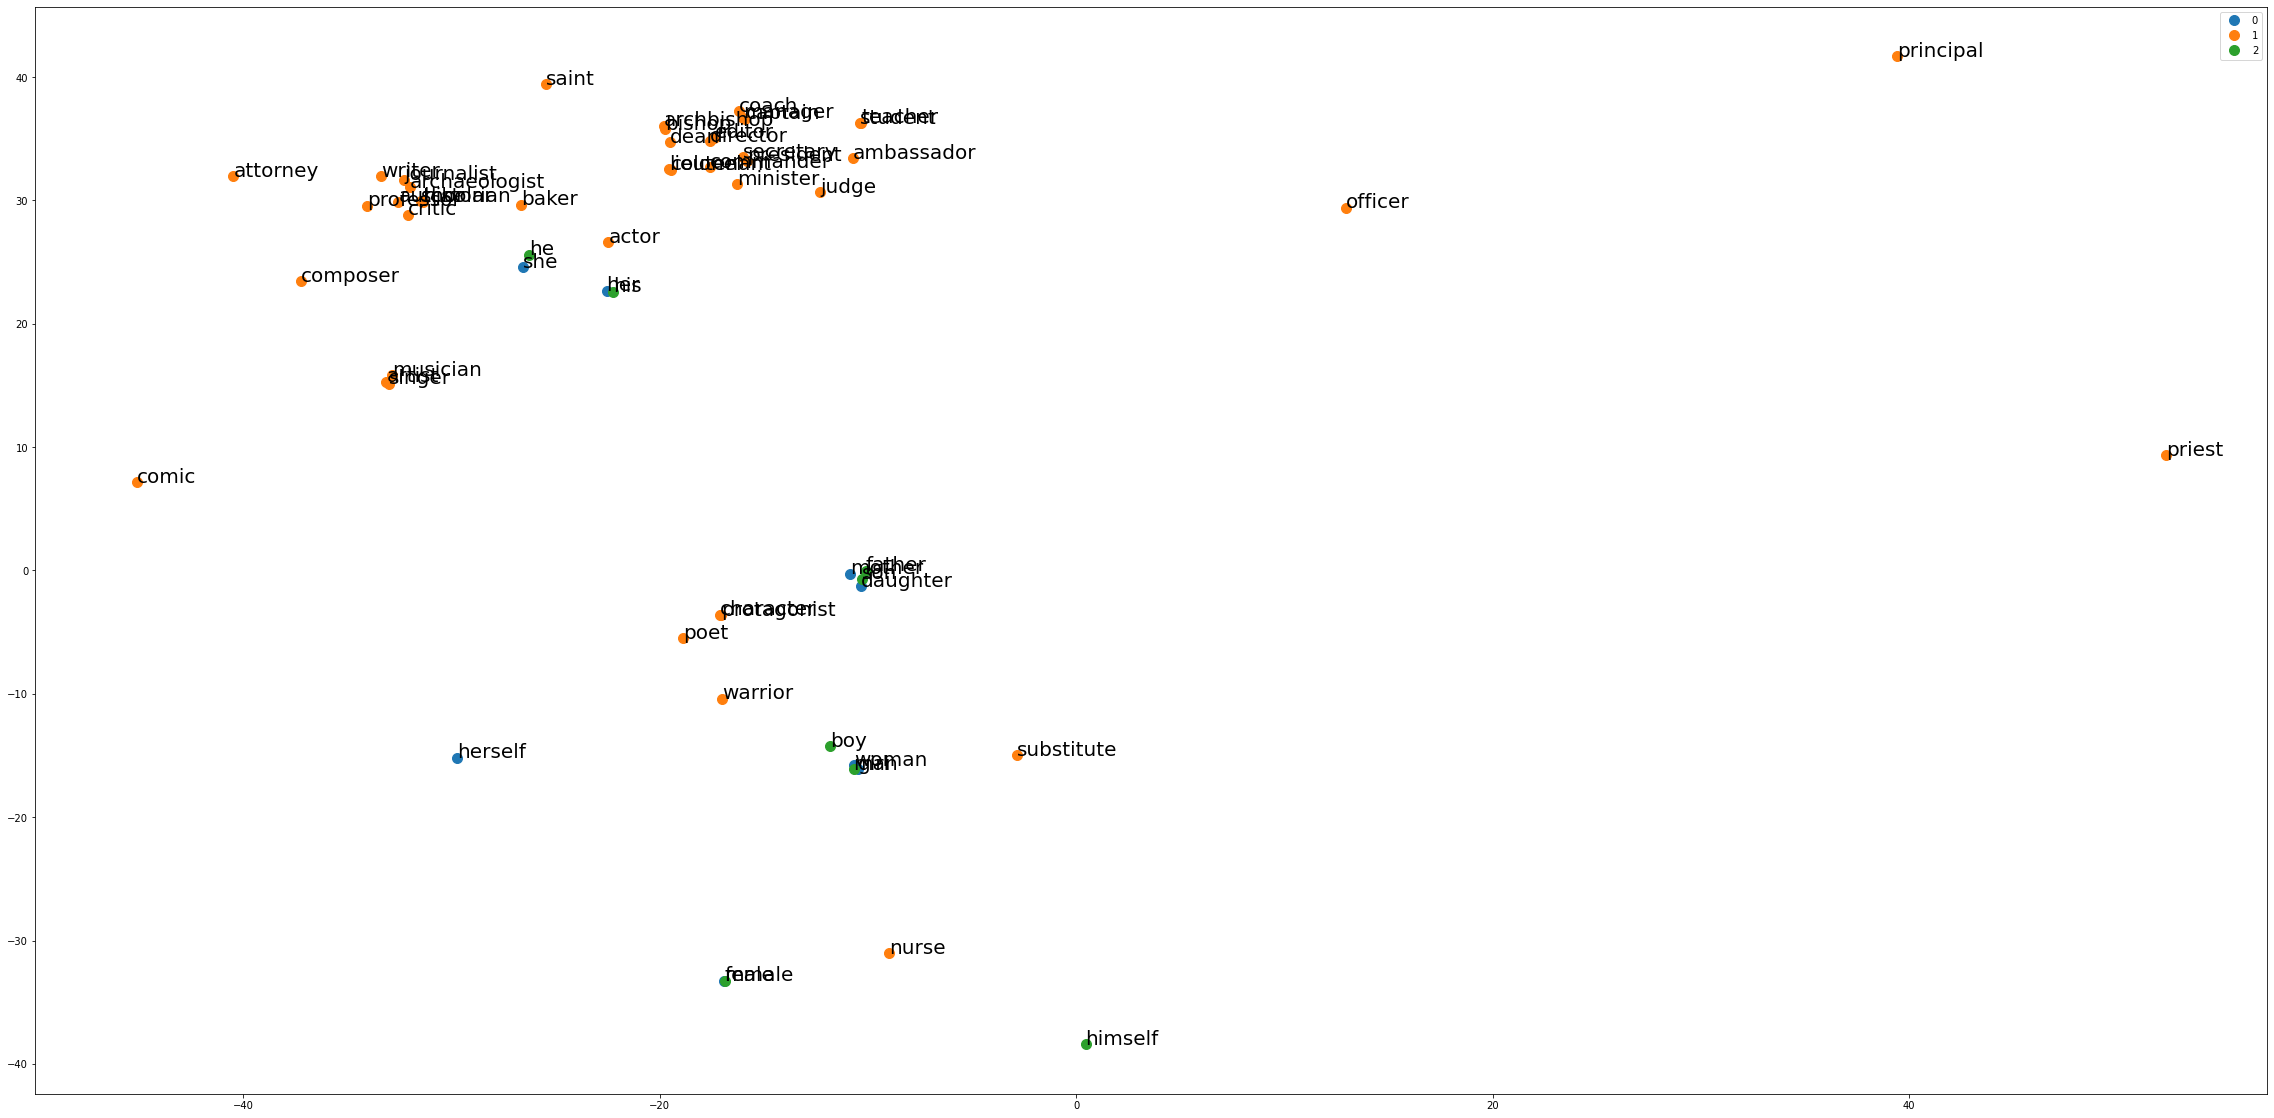

In [358]:
all_vocab = Female_Vocab.tolist() + Neutral_Vocab.tolist() + Male_Vocab.tolist()
all_words = female_list + gender_neutral_pro + male_list
print(len(all_words))
print(len(all_vocab))

tsne_array = embeddings_df_trans.to_numpy()
xs = []
ys = []
x_text = []
y_text = []
for v in all_vocab:
  data = tsne_array[v]
  xs.append(data[0][0])
  ys.append(data[0][1])

labels = [0] * len(female_list) + [1] * len(gender_neutral_pro) + [2] * len(male_list)

df = pd.DataFrame(dict(x=xs, y=ys, label=labels))

groups = df.groupby('label')

import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(40, 20))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
for i in range(len(xs)):
    ax.annotate(all_words[i], (xs[i], ys[i]), size=20)
ax.legend()

plt.show()


In [334]:
print(abs(((embeddings[Female_Vocab.cpu()]-embeddings[Neutral_Vocab.cpu()].reshape(1, -1, 300))**2)- ((embeddings[Male_Vocab.cpu()]-embeddings[Neutral_Vocab.cpu()].reshape(1, -1, 300))**2)).mean())

0.0054219454


In [332]:
print(embeddings[Female_Vocab.cpu()])

[[[ 2.7523055e-03 -2.3197155e-02 -1.5992628e-03 ... -1.2514526e-02
    2.0741052e-03  3.6826618e-02]]

 [[ 1.0913976e-03 -1.4339906e-02 -9.7837322e-04 ... -7.8110616e-03
    1.3085976e-03  2.3174118e-02]]

 [[ 1.3073382e-02 -2.9736519e-01 -1.0561150e-03 ... -1.9354096e-02
   -2.5358045e-02  1.5764977e-01]]

 ...

 [[ 8.0778741e-04 -1.4327645e-02 -2.2003877e-03 ... -8.6070132e-03
    1.2644922e-03  1.8307647e-02]]

 [[ 7.8426890e-02 -7.5879551e-02  2.7785343e-04 ... -4.5473740e-02
   -2.7389310e-02  5.9970934e-02]]

 [[ 8.2479045e-04 -1.1433492e-02 -1.2471934e-03 ... -7.4667074e-03
    1.8176185e-03  1.7766647e-02]]]


In [ ]:
def get_top_similar(word: str, topN: int = 10):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

dic = get_top_similar("germany")

for word, sim in dic.items():
    print("{}: {:.3f}".format(word, sim))

emb1 = embeddings[vocab["king"]]
emb2 = embeddings[vocab["man"]]
emb3 = embeddings[vocab["woman"]]

emb4 = emb1 - emb2 + emb3
emb4_norm = (emb4 ** 2).sum() ** (1 / 2)
emb4 = emb4 / emb4_norm

emb4 = np.reshape(emb4, (len(emb4), 1))
dists = np.matmul(embeddings_norm, emb4).flatten()

top5 = np.argsort(-dists)[:5]

for word_id in top5:
    print(word_id)
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dists[word_id]))

In [337]:
import re
import sys
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA

class WordEmbedding:
    def __init__(self):
        self.thresh = None
        self.max_words = None
        #self.vecs = embeddings
        #print(self.vecs.shape)
        #self.words = vocab
        self.words =[vocab.lookup_token(i) for i in range(len(vocab))]
        print(self.words)
        print(len(self.words))
        self.vecs = [embeddings[vocab[w]] for w in self.words]
        self.vecs = np.array(self.vecs, dtype='float32')
        print(self.vecs.shape)
        self.reindex()
        norms = np.linalg.norm(self.vecs, axis=1)
        if max(norms)-min(norms) > 0.0001:
            self.normalize()

    def reindex(self):
        self.index = {w: i for i, w in enumerate(self.words)}
        self.n, self.d = self.vecs.shape
        assert self.n == len(self.words) == len(self.index)
        self._neighbors = None
        print(self.n, "words of dimension", self.d, ":", ", ".join(self.words[:4] + ["..."] + self.words[-4:]))


    def v(self, word):
        return self.vecs[self.index[word]]

    def diff(self, word1, word2):
        v = self.vecs[self.index[word1]] - self.vecs[self.index[word2]]
        return v/np.linalg.norm(v)

    def normalize(self):
        self.vecs /= np.linalg.norm(self.vecs, axis=1)[:, np.newaxis]

    def shrink(self, numwords):
        self.desc += ", shrink " + str(numwords)
        self.filter_words(lambda w: self.index[w]<numwords)

    def filter_words(self, test):
        """
        Keep some words based on test, e.g. lambda x: x.lower()==x
        """
        self.desc += ", filter"
        kept_indices, words = zip(*[[i, w] for i, w in enumerate(self.words) if test(w)])
        self.words = list(words)
        self.vecs = self.vecs[kept_indices, :]
        self.reindex()

    def save(self, filename):
        with open(filename, "w") as f:
            f.write("\n".join([w+" " + " ".join([str(x) for x in v]) for w, v in zip(self.words, self.vecs)]))
        print("Wrote", self.n, "words to", filename)

    def save_w2v(self, filename, binary=True):
        with open(filename, 'wb') as fout:
            fout.write(to_utf8("%s %s\n" % self.vecs.shape))
            # store in sorted order: most frequent words at the top
            for i, word in enumerate(self.words):
                row = self.vecs[i]
                if binary:
                    fout.write(to_utf8(word) + b" " + row.tostring())
                else:
                    fout.write(to_utf8("%s %s\n" % (word, ' '.join("%f" % val for val in row))))

    def remove_directions(self, directions): #directions better be orthogonal
        self.desc += ", removed"
        for direction in directions:
            self.desc += " "
            if type(direction) is np.ndarray:
                v = direction / np.linalg.norm(direction)
                self.desc += "vector "
            else:
                w1, w2 = direction
                v = self.diff(w1, w2)
                self.desc += w1 + "-" + w2
            self.vecs = self.vecs - self.vecs.dot(v)[:, np.newaxis].dot(v[np.newaxis, :])
        self.normalize()

    def compute_neighbors_if_necessary(self, thresh, max_words):
        thresh = float(thresh) # dang python 2.7!
        if self._neighbors is not None and self.thresh == thresh and self.max_words == max_words:
            return
        print("Computing neighbors")
        self.thresh = thresh
        self.max_words = max_words
        vecs = self.vecs[:max_words]
        dots = vecs.dot(vecs.T)
        dots = scipy.sparse.csr_matrix(dots * (dots >= 1-thresh/2))
        from collections import Counter
        rows, cols = dots.nonzero()
        nums = list(Counter(rows).values())
        print("Mean:", np.mean(nums)-1)
        print("Median:", np.median(nums)-1)
        rows, cols, vecs = zip(*[(i, j, vecs[i]-vecs[j]) for i, j, x in zip(rows, cols, dots.data) if i<j])
        self._neighbors = rows, cols, np.array([v/np.linalg.norm(v) for v in vecs])

    def neighbors(self, word, thresh=1):
        dots = self.vecs.dot(self.v(word))
        return [self.words[i] for i, dot in enumerate(dots) if dot >= 1-thresh/2]

    def more_words_like_these(self, words, topn=50, max_freq=100000):
        v = sum(self.v(w) for w in words)
        dots = self.vecs[:max_freq].dot(v)
        thresh = sorted(dots)[-topn]
        words = [w for w, dot in zip(self.words, dots) if dot>=thresh]
        return sorted(words, key=lambda w: self.v(w).dot(v))[-topn:][::-1]

    def best_analogies_dist_thresh(self, v, thresh=1, topn=500, max_words=50000):
        """Metric is cos(a-c, b-d) if |b-d|^2 < thresh, otherwise 0
        """
        vecs, vocab = self.vecs[:max_words], self.words[:max_words]
        self.compute_neighbors_if_necessary(thresh, max_words)
        rows, cols, vecs = self._neighbors
        scores = vecs.dot(v/np.linalg.norm(v))
        pi = np.argsort(-abs(scores))

        ans = []
        usedL = set()
        usedR = set()
        for i in pi:
            if abs(scores[i])<0.001:
                break
            row = rows[i] if scores[i] > 0 else cols[i]
            col = cols[i] if scores[i] > 0 else rows[i]
            if row in usedL or col in usedR:
                continue
            usedL.add(row)
            usedR.add(col)
            ans.append((vocab[row], vocab[col], abs(scores[i])))
            if len(ans)==topn:
                break

        return ans

def viz(analogies):
    print("\n".join(str(i).rjust(4)+a[0].rjust(29) + " | " + a[1].ljust(29) + (str(a[2]))[:4] for i, a in enumerate(analogies)))


def text_plot_words(xs, ys, words, width = 90, height = 40, filename=None):
    PADDING = 10 # num chars on left and right in case words spill over
    res = [[' ' for i in range(width)] for j in range(height)]
    def rescale(nums):
        a = min(nums)
        b = max(nums)
        return [(x-a)/(b-a) for x in nums]
    print("x:", (min(xs), max(xs)), "y:",(min(ys),max(ys)))
    xs = rescale(xs)
    ys = rescale(ys)
    for (x, y, word) in zip(xs, ys, words):
        i = int(x*(width - 1 - PADDING))
        j = int(y*(height-1))
        row = res[j]
        z = list(row[i2] != ' ' for i2 in range(max(i-1, 0), min(width, i + len(word) + 1)))
        if any(z):
            continue
        for k in range(len(word)):
            if i+k>=width:
                break
            row[i+k] = word[k]
    string = "\n".join("".join(r) for r in res)
#     return string
    if filename:
        with open(filename, "w", encoding="utf8") as f:
            f.write(string)
        print("Wrote to", filename)
    else:
        print(string)


def doPCA(pairs, embedding, num_components = 10):
    matrix = []
    for a, b in pairs:
        center = (embedding.v(a) + embedding.v(b))/2
        matrix.append(embedding.v(a) - center)
        matrix.append(embedding.v(b) - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca


def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

In [338]:
we = WordEmbedding()
v_gender = we.diff('she', 'he')
#print(v_gender)
a_gender = we.best_analogies_dist_thresh(v_gender)
for (a,b,c) in a_gender:
    print(a+"-"+b)

['<unk>', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a', '=', 'was', "'", '@-@', 'on', 'as', 's', 'that', 'for', 'with', 'by', ')', '(', '@', 'is', 'it', 'from', 'at', 'his', 'he', 'were', 'an', 'had', 'which', 'be', 'are', 'this', 'their', 'first', 'but', 'not', '–', 'one', 'they', 'its', 'also', 'after', 'her', 'or', 'two', 'have', 'has', 'been', 'who', 'she', 'new', 'other', 'during', 'when', 'time', 'all', 'into', 'more', 'would', '1', 'i', 'over', 'while', 'game', 'only', 'most', '2', 'three', 'later', 'about', 'up', 'may', 'between', 'him', 'song', 'there', 'some', 'than', 'out', 'no', 'season', 'year', 'made', 'city', '3', 'such', 'before', 'where', 'used', 'series', 'them', 'second', 'world', 'being', 'years', 'both', '000', 'many', 'these', 'film', 'however', 'album', 'south', 'war', 'through', '5', 'north', 'then', 'can', 'part', 'early', 'several', '4', 'number', 'state', 'including', 'against', 'well', '/', 'known', 'became', '—', 'm', 'four', 'united', 'under', 'although',

In [276]:
# profession analysis gender
sp = sorted([(we.v(w).dot(v_gender), w) for w in gender_neutral_pro])

sp[:10], sp[-10:]

([(-0.031181991, 'dean'),
  (-0.009897577, 'priest'),
  (-0.009179587, 'manager'),
  (-0.0041471263, 'archbishop'),
  (-0.0037007688, 'president'),
  (-0.0030350243, 'historian'),
  (-0.0029313213, 'coach'),
  (-0.0025210085, 'baker'),
  (-0.0018131492, 'substitute'),
  (-0.0006827671, 'editor')],
 [(0.014772066, 'writer'),
  (0.015275482, 'lieutenant'),
  (0.015998024, 'character'),
  (0.016887365, 'comic'),
  (0.017007533, 'composer'),
  (0.01982513, 'ambassador'),
  (0.022993831, 'colonel'),
  (0.024519522, 'journalist'),
  (0.030702982, 'artist'),
  (0.05640083, 'scholar')])

In [275]:
print(embeddings)

[[-3.0526235e-03  3.1107708e-03 -1.8751865e-03 ...  6.4319046e-04
   4.4449414e-05 -5.0280668e-04]
 [-3.9040020e-01  8.2759780e-01 -2.6692277e-01 ... -8.4035061e-02
   2.9124224e-01 -3.3689551e+00]
 [-1.4071272e-01 -3.0223379e-01 -1.4654145e-01 ...  1.4267842e-02
   2.1485694e-01  4.5167241e-01]
 ...
 [-8.2710490e-02 -3.9616134e-03 -2.5108871e-01 ... -8.6660497e-02
   3.3883905e-01  3.9474577e-01]
 [-6.9013965e-01  2.5743973e-01 -2.4848592e-01 ...  8.7869614e-01
   4.7548008e-01  1.0485433e+00]
 [-6.0571045e-01 -6.4031237e-01 -4.3469277e-01 ... -9.6149147e-01
   4.7543150e-01 -4.3673083e-01]]


In [6]:
import torch
print(torch.empty((0, 300)).nelement()==0)

True
